In [4]:
import os
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random
from sklearn.neighbors.kde import KernelDensity


In [27]:
#dataset_name = 'ihart.ms2'
#ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped']
#assembly = '38'

#dataset_name = 'all_datasets'
#ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped',
#             '../../DATA/spark/sparkfam.ped',
#             '../../DATA/ssc/ssc.ped'
#            ]
#assembly = '38'

dataset_name = 'spark'
ped_files = ['../../DATA/spark/sparkfam.ped']
assembly = '38'

#phase_dir = '../phased_ancestry_quads_del'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#assembly = '38'

In [28]:
child_to_mom = dict()
child_to_dad = dict()

sample_to_sex = dict()
sample_to_affected = dict()
parents_to_children = defaultdict(list)

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            sample_to_sex[pieces[1]] = pieces[4]
            sample_to_affected[pieces[1]] = pieces[5]
            if pieces[2] != '0' and pieces[3] != '0':
                parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
                child_to_mom[pieces[1]] = pieces[3]
                child_to_dad[pieces[1]] = pieces[2]                

In [29]:
sibpair_to_num_crossovers_mat = dict()
sibpair_to_num_crossovers_pat = dict()

sibpair_to_ibd_mat = dict()
sibpair_to_ibd_pat = dict()

with open('../%s/sibpairs.json' % dataset_name, 'r') as f:
    sibpairs = json.load(f)
    
already_included = set()
for (phase_file, family, child1, child2), mat_ibd, pat_ibd, mat_crossovers, pat_crossovers in sibpairs:
    if child1 not in already_included and child2 not in already_included:
        sibpair_to_num_crossovers_mat[(child1, child2)] = mat_crossovers
        sibpair_to_num_crossovers_pat[(child1, child2)] = pat_crossovers
        sibpair_to_ibd_mat[(child1, child2)] = mat_ibd
        sibpair_to_ibd_pat[(child1, child2)] = pat_ibd
        already_included.add(child1)
        already_included.add(child2)
                
print(len(sibpair_to_num_crossovers_mat), len(sibpair_to_num_crossovers_pat), len(already_included))

sibpairs = [(x[0][2], x[0][3]) for x in sibpairs]



5674 5674 11348


In [30]:
print(sibpairs[:2])

[('SP0000027', 'SP0000034'), ('SP0000063', 'SP0000027')]


# Check phenotype

In [31]:
sibpairs_to_include_mat = [x for x in sibpair_to_num_crossovers_mat.keys() if (sample_to_affected.get(x[0], None) in {'1', '2'}) and (sample_to_affected.get(x[1], None) in {'1', '2'})]
sibpairs_to_include_pat = [x for x in sibpair_to_num_crossovers_pat.keys() if (sample_to_affected.get(x[0], None) in {'1', '2'}) and (sample_to_affected.get(x[1], None) in {'1', '2'})]

children_to_include_mat = sum([list(x) for x in sibpairs_to_include_mat], [])
children_to_include_pat = sum([list(x) for x in sibpairs_to_include_pat], [])


In [32]:
phenotype_mat = np.array([int(sample_to_affected[sib1]=='2') + int(sample_to_affected[sib2]=='2') for sib1, sib2 in sibpairs_to_include_mat])
phenotype_pat = np.array([int(sample_to_affected[sib1]=='2') + int(sample_to_affected[sib2]=='2') for sib1, sib2 in sibpairs_to_include_pat])

mom_recomb = np.array([sibpair_to_num_crossovers_mat[x] for x in sibpairs_to_include_mat])
dad_recomb = np.array([sibpair_to_num_crossovers_pat[x] for x in sibpairs_to_include_pat])
print(Counter(phenotype_mat), Counter(phenotype_pat))


Counter({1: 4452, 2: 1168, 0: 49}) Counter({1: 4452, 2: 1168, 0: 49})


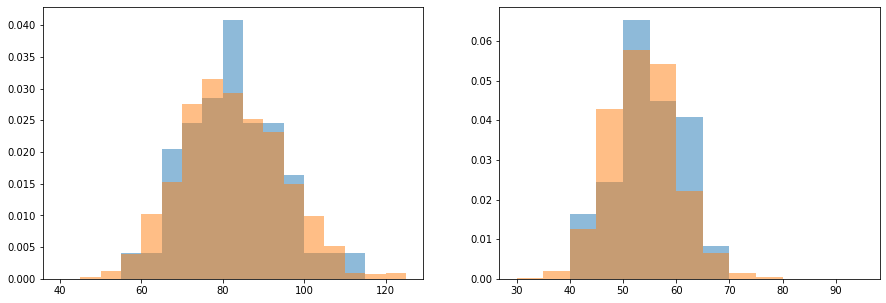

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(mom_recomb[phenotype_mat==0], alpha=0.5, density=True, bins=np.arange(40, 130, 5))
#plt.hist(mom_recomb[phenotype_mat==1], alpha=0.5, density=True, bins=np.arange(40, 130, 5))
plt.hist(mom_recomb[phenotype_mat==2], alpha=0.5, density=True, bins=np.arange(40, 130, 5))

plt.subplot(1, 2, 2)
plt.hist(dad_recomb[phenotype_pat==0], alpha=0.5, density=True, bins=np.arange(30, 100, 5))
#plt.hist(dad_recomb[phenotype_pat==1], alpha=0.5, density=True, bins=np.arange(30, 100, 5))
plt.hist(dad_recomb[phenotype_pat==2], alpha=0.5, density=True, bins=np.arange(30, 100, 5))

plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(mom_age, mom_ibd, marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mom_age[:, np.newaxis],
                                                                    mom_ibd[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(mom_ibd, mom_age, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(mom_age, mom_ibd),
                )
plt.legend()

plt.subplot(1, 2, 2)

plt.scatter(dad_age, dad_ibd, marker='.', alpha=0.25)

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((dad_age[:, np.newaxis],
                                                                    dad_ibd[:, np.newaxis]))) 
xintervals = plt.xticks()[0]
yintervals = plt.yticks()[0]
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

l = sm.nonparametric.lowess(dad_ibd, dad_age, return_sorted=True)
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(dad_age, dad_ibd),
                )
plt.legend()
plt.show()

In [ ]:
mat_model = sm.GLM(mom_recomb, mom_age_X)
mat_results = mat_model.fit()
print(mat_results.summary())

pat_model = sm.GLM(dad_recomb, dad_age_X)
pat_results = pat_model.fit()
print(pat_results.summary())



In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = np.zeros((len(age_intervals_mat)+1, len(age_intervals_mat)+2))
p[:, :-1] = np.identity(len(age_intervals_mat)+1)
print()
p[:, -1] = 1

presults = mat_results.get_prediction(p)

plt.plot([age_intervals_mat[0]-5] + age_intervals_mat.tolist(), mat_results.predict(p), marker='o')
plt.fill_between([age_intervals_mat[0]-5] + age_intervals_mat.tolist(),
                 presults.conf_int()[:, 0], presults.conf_int()[:, 1], alpha=0.25)

plt.subplot(1, 2, 2)

p = np.zeros((len(age_intervals_pat)+1, len(age_intervals_pat)+2))
p[:, :-1] = np.identity(len(age_intervals_pat)+1)
print()
p[:, -1] = 1

presults = pat_results.get_prediction(p)

plt.plot([age_intervals_pat[0]-5] + age_intervals_pat.tolist(), pat_results.predict(p), marker='o')
plt.fill_between([age_intervals_pat[0]-5] + age_intervals_pat.tolist(),
                 presults.conf_int()[:, 0], presults.conf_int()[:, 1], alpha=0.25)

plt.tight_layout()
plt.show()


In [ ]:
mat_model = sm.GLM(mom_recomb, mom_age_phen)
mat_results = mat_model.fit()
print(mat_results.summary())

pat_model = sm.GLM(dad_recomb, dad_age_phen)
pat_results = pat_model.fit()
print(pat_results.summary())



In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

p = [[20, 0, 1, 0],
     [100, 0, 1, 0],
     [0, 20, 0, 1],
     [0, 100, 0, 1]]

presults = mat_results.get_prediction(p)

plt.plot([20, 100], mat_results.predict(p)[:2], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([20, 100], mat_results.predict(p)[2:], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.subplot(1, 2, 2)

presults = pat_results.get_prediction(p)

plt.plot([20, 100], pat_results.predict(p)[:2], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[:2, 0], presults.conf_int()[:2, 1], alpha=0.25)

plt.plot([20, 100], pat_results.predict(p)[2:], marker='o')
plt.fill_between([20, 100],
                 presults.conf_int()[2:, 0], presults.conf_int()[2:, 1], alpha=0.25)

plt.tight_layout()
plt.show()
